# 5. Segregation Indexes

Following the Bojanowski & Corten Paper _Measuring Segregation in Social Networks_ 2014, We calculate some segregation indexes for our graphs along the time.

## Prerequistes

In [83]:
import numpy as np
import pandas as pd
import pickle
import graph_tool as gt
from graph_tool.spectral import adjacency
import scipy.sparse as sp
from glob import glob
from tqdm import tqdm

In [84]:
# Load Types Matrix
data = np.load('/mnt/disk2/Data/Matrices/Useful_Matrices/types_matrix.npz')
indices = data['indices']
indptr = data['indptr']
shape = data['shape']
data = data['data']
types = sp.csr_matrix((data, indices, indptr), shape = shape)

# Types Matrix is a crs matrix. The types of the matrix is as follows: Derecha, Izquierda, Centro, No Retweet
types

<37337x4 sparse matrix of type '<class 'numpy.int32'>'
	with 37337 stored elements in Compressed Sparse Row format>

In [85]:
#In this first attempt, our types matrix looks like this
N, K = types.shape
Eta_0 = np.sum(types[:,0])
Eta_1 = np.sum(types[:,1])
Eta_2 = np.sum(types[:,2])
Eta_3 = np.sum(types[:,3])
Eta_k = np.array([Eta_0, Eta_1, Eta_2, Eta_3])

# We show this amounts
print(f'Cantidad de nodos:{N}')
print(f'Cantidad de grupos:{K}')
print(f'Tweets de Derecha: {Eta_0}')
print(f'Tweets de Izquierda: {Eta_1}')
print(f'Tweets de Centro: {Eta_2}')
print(f'No Retweets: {Eta_3}')

Cantidad de nodos:37337
Cantidad de grupos:4
Tweets de Derecha: 6812
Tweets de Izquierda: 23138
Tweets de Centro: 3543
No Retweets: 3844


In [87]:
def freeman(adj: np.array, types: np.array):
    # We get the amount of vertices and groups
    N, K = types.shape
    
    # Get the amount of nodes per group
    Eta_k =[]
    for k in range(K):
        Eta = np.sum(types[:, k])
        Eta_k.append(Eta)
    Eta_k = np.array(Eta_k)
    
    # Calculate the contact layer Corresponds to the number of relation between and within groups acoording to the groups indexes
    M = types.transpose().dot(adj).dot(types)
    M = M.toarray()
    M = np.triu(M)
    M_no_diag = np.triu(M,k=1)

    # Calculate P 
    P = M_no_diag.sum() / M.sum()

    # Prepare for calculation
    numerator = P * N * (N - 1)
    denominator = (Eta_k.sum() **2) - (np.sum(Eta_k **2))

    # calculate using the formula
    S = 1 - (numerator / denominator)
    
    return S

In [92]:
# Load Adjacency matrices
files = glob('/mnt/disk2/Data/Matrices/3_Day_Window/*csr.npz')
segregation = []
date = []
for file in files:
    #Loading the Adjacency Matrix as CRS
    data = np.load(file)
    indices = data['indices']
    indptr = data['indptr']
    shape = data['shape']
    data = data['data']
    adj = sp.csr_matrix((data, indices, indptr), shape = shape)

    #Getting the name of the Matrix
    adjacency_name = file.split('/')[-1].split('.')[0].split('_')[-1]

    #Calculating and reporting the freeman Index
    #print(f'Freeman Segregación index for {adjacency_name} is {freeman(adj,types)}')

    #Appending it to the 
    segregation.append(freeman(adj,types))
    date.append(adjacency_name)

In [95]:
data = {
    'segregation': segregation,
    'dates': date
}
data_viz = pd.DataFrame(data)

/home/fcastrillon/.conda/envs/gt/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


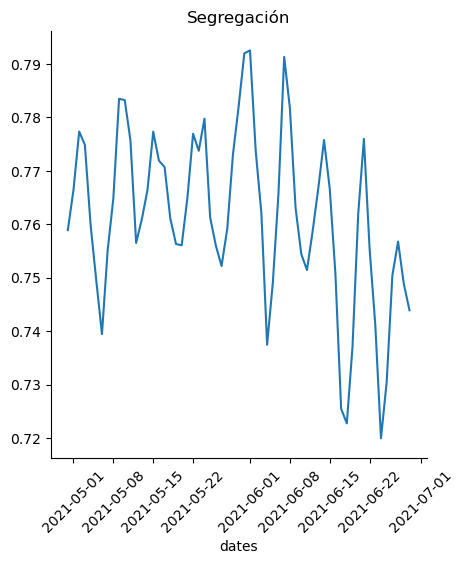

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

dates = pd.to_datetime(data_viz['dates'], format='%d-%m-%Y')

sns.relplot(x=dates, y=segregation, kind = 'line')
plt.title('Segregación')
plt.xticks(rotation=45)
plt.show()